In [2]:
import numpy as np
import scipy.sparse as sp
# from time import time
from matplotlib import pyplot as plt
from sklearn.utils.extmath import randomized_svd

Generowanie macierzy

In [3]:
def generate_3d_grid_matrix(k):
    size = 2**(3*k)
    grid_size = 2**k

    # Inicjalizacja rzadkiej macierzy
    matrix = sp.lil_matrix((size, size), dtype=float)

    # Iteracja przez elementy sześcienne siatki
    for i in range(grid_size):
        for j in range(grid_size):
            for l in range(grid_size):
                # Indeks aktualnego wierzchołka
                current_vertex = i * grid_size**2 + j * grid_size + l

                # Iteracja przez sąsiadów
                for di, dj, dl in [(-1, 0, 0), (1, 0, 0), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)]:
                    ni, nj, nl = i + di, j + dj, l + dl

                    # Sprawdzenie, czy sąsiad mieści się w siatce
                    if 0 <= ni < grid_size and 0 <= nj < grid_size and 0 <= nl < grid_size:
                        neighbor_vertex = ni * grid_size**2 + nj * grid_size + nl

                        # Przypisanie losowej wartości sąsiadowi
                        matrix[current_vertex, neighbor_vertex] = np.random.rand()

    return matrix

# test
for k in range(2, 5):
    matrix = generate_3d_grid_matrix(k)
    print(f"Matrix for k={k}:\n{matrix.toarray()}\n")

Matrix for k=2:
[[0.         0.33839371 0.         ... 0.         0.         0.        ]
 [0.46492516 0.         0.82159616 ... 0.         0.         0.        ]
 [0.         0.18354215 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.56830132 0.        ]
 [0.         0.         0.         ... 0.00320423 0.         0.21932199]
 [0.         0.         0.         ... 0.         0.1625537  0.        ]]

Matrix for k=3:
[[0.         0.41762879 0.         ... 0.         0.         0.        ]
 [0.56711324 0.         0.24317644 ... 0.         0.         0.        ]
 [0.         0.37235503 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.13948492 0.        ]
 [0.         0.         0.         ... 0.38401997 0.         0.45572681]
 [0.         0.         0.         ... 0.         0.54217838 0.        ]]

Matrix for k=4:
[[0.         0.71957578 0.         ... 0.         0.         0

Kompresja macierzy

In [4]:
class Node:
    def __init__(self, t_min, t_max, s_min, s_max):
        self.t_min = t_min
        self.t_max = t_max
        
        self.s_min = s_min
        self.s_max = s_max
        
        self.rank = None
        
        #[A11, A12]
        #[A21, A22]
        
        self.U = None
        self.S = None
        self.VT = None
        
        self.zeros = False
        
        
        self.children = []

In [5]:
def is_admissible(matrix, S, r, eps):
    if min(matrix.shape) <= r:
        return True
    
    if S[-1] < eps:
        return True
    
    return False     

In [6]:
def create_tree(matrix, r, eps):
    n, m = matrix.shape

    
    def create_tree_r(t_min, t_max, s_min, s_max):
        nonlocal matrix, r, eps
        
        if not np.any(matrix[t_min:t_max, s_min:s_max]):
            v = Node(t_min, t_max, s_min, s_max)
            v.rank = 0
            v.zeros = True
            return v
    
        U,S,V = randomized_svd(matrix[t_min:t_max, s_min:s_max], r)
        
        # S = S[S >= eps]  
        # rank = len(S)
        
        # U = U[:, :rank]
        # V = V[:rank, :]
        # if rank == 0:
        #     v = Node(t_min, t_max, s_min, s_max)
        #     v.rank = 0
        #     v.zeros = True
        #     return v
        
        
        if is_admissible(matrix[t_min:t_max, s_min:s_max], S, r, eps):
            v = Node(t_min, t_max, s_min, s_max) #compress matrix
            v.rank = r
            v.U = U
            v.S = S
            v.V = V
            return v
            
        else:
            v = Node(t_min, t_max, s_min, s_max)
            
            t_newmax = (t_min + t_max)//2
            s_newmax = (s_min + s_max)//2
            
            v1 = create_tree_r(t_min, t_newmax, s_min, s_newmax)
            v2 = create_tree_r(t_min, t_newmax, s_newmax, s_max)
            v3 = create_tree_r(t_newmax, t_max, s_min, s_newmax)
            v4 = create_tree_r(t_newmax, t_max, s_newmax, s_max)
            
            v.children = [v1, v2, v3, v4]
        return v
    return create_tree_r(0, n, 0, m)

In [7]:
def decompress(node):
    if node.rank is not None:
        if node.rank > 0:
            return node.U@np.diag(node.S)@node.V
        else:
            return np.zeros((node.t_max - node.t_min, node.s_max - node.s_min))
    else:
        return np.vstack(
            (
                np.hstack((decompress(node.children[0]), decompress(node.children[1]))),
                np.hstack((decompress(node.children[2]), decompress(node.children[3]))),
            )
        )   

Rysowacz:)

In [8]:
def plot_matrix(root, matrix, title = None):
    size = matrix.shape
    tmap = np.zeros(size)
    
    def fill_map(node):
        nonlocal tmap
        if node.rank is not None:
            if node.rank != 0:
                tmap[node.t_min:node.t_max, node.s_min:node.s_min + node.rank] = 1
                tmap[node.t_min:node.t_min + node.rank, node.s_min:node.s_max] = 1
        else:
            for submatrix in node.children:
                fill_map(submatrix)
    fill_map(root)
    _, ax = plt.subplots(1,1)
    ax.spy(tmap)
    if title is not None:
        ax.set_title(title)
        
def plot_sparisity(matrix, title=None):
    _, ax = plt.subplots(1,1)
    ax.spy(matrix)
    if title is not None:
        ax.set_title(title)

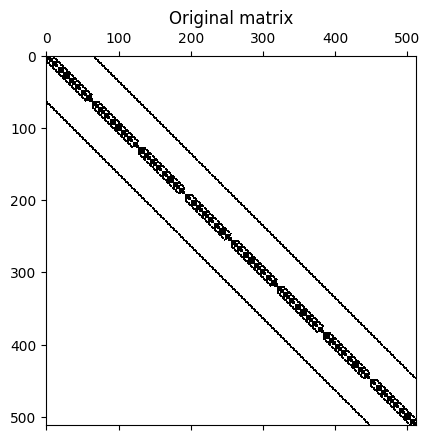

In [9]:
matrix = generate_3d_grid_matrix(3).toarray()
root = create_tree(matrix, 3, 10**(-8))
plot_matrix(root, matrix, "Original matrix")

Permutacje macierzy

In [10]:
def permutate_matrix(matrix, permutation):
    size = len(matrix)
    new_matrix = np.zeros((size, size))
    for i in range(size):
        new_matrix[i] = matrix[permutation[i]]
    
    new_matrix_cols = np.zeros((size, size))
    for i in range(size):
        new_matrix_cols[:, i] = new_matrix[:, permutation[i]]
            
    return new_matrix_cols

In [11]:
def minimum_degree_ordering(matrix):
    n = len(matrix)
    permutation = [None for _ in range(n)]
    adjacent = {i:set() for i in range(n)}
    
    for i in range(n):
        for j in range(n):
            if matrix[i][j] != 0:
                adjacent[i].add(j)
                
    for i in range(n):
        min_deg = n + 1
        min_idx = None
        for idx, deg in adjacent.items():
            if len(deg) < min_deg:
                min_idx = idx
                min_deg = len(deg)
                
        permutation[i] = min_idx
        
        
        for j in adjacent:
            adjacent[j].discard(min_idx)
        for v in adjacent[min_idx]:
            adjacent[v].update(adjacent[min_idx] - {v})
        adjacent.pop(min_idx)

    return permutation

In [12]:
def cuthill_mckee_ordering(matrix):
    n = len(matrix)
    permutation = []
    adjacent = {i: set() for i in range(n)}
    visited = [False for _ in range(n)]

    def bfs(vertex):
        nonlocal visited, permutation, adjacent
        queue = [vertex]
        visited[vertex] = True

        while queue:
            current_vertex = queue.pop(0)
            permutation.append(current_vertex)

            for v in sorted(adjacent[current_vertex], key=lambda x: len(adjacent[x])):
                if not visited[v]:
                    queue.append(v)
                    visited[v] = True

    for i in range(n):
        for j in range(n):
            if matrix[i][j] != 0:
                adjacent[i].add(j)

    sorted_vertices = sorted(range(n), key=lambda x: len(adjacent[x]))

    for vertex in sorted_vertices:
        if not visited[vertex]:
            bfs(vertex)

    return permutation


In [13]:
def reversed_cuthill_ordering(matrix):
    return cuthill_mckee_ordering(matrix)[::-1]

Test permutacji

In [14]:
matrix = generate_3d_grid_matrix(3).toarray()
_, S, _ = np.linalg.svd(matrix)

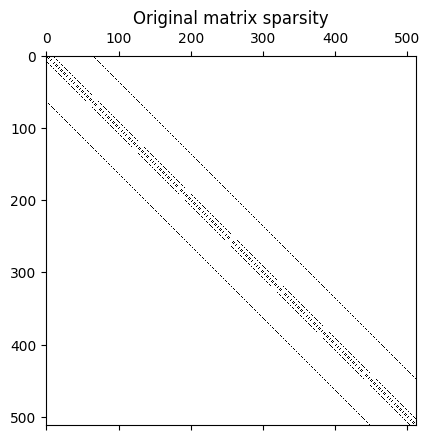

In [15]:
plot_sparisity(matrix, "Original matrix sparsity")

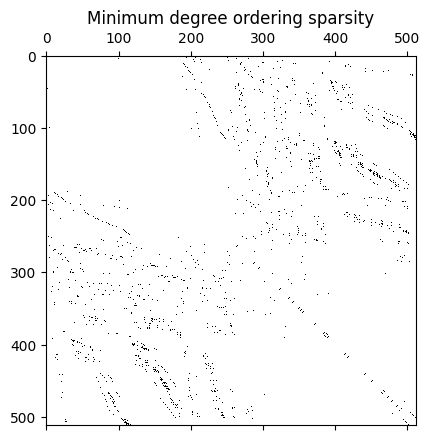

In [16]:
perm_matrix = permutate_matrix(matrix, minimum_degree_ordering(matrix))
plot_sparisity(perm_matrix, "Minimum degree ordering sparsity")

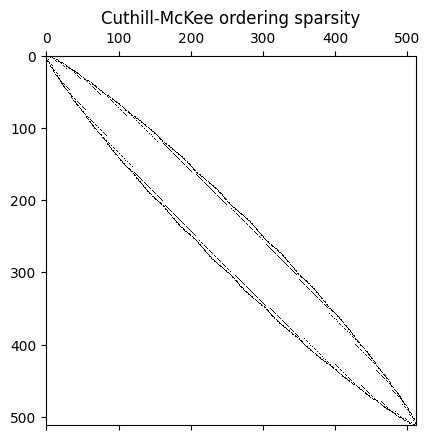

In [17]:
perm_matrix = permutate_matrix(matrix, cuthill_mckee_ordering(matrix))
plot_sparisity(perm_matrix, "Cuthill-McKee ordering sparsity")

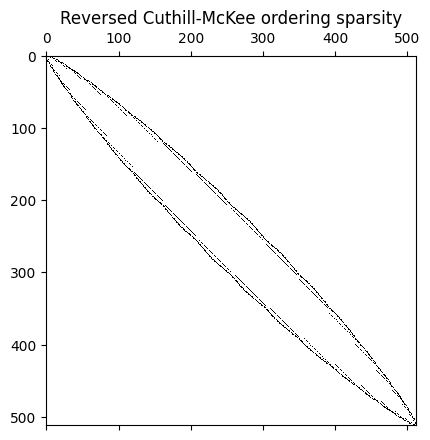

In [18]:
perm_matrix = permutate_matrix(matrix, reversed_cuthill_ordering(matrix))
plot_sparisity(perm_matrix, "Reversed Cuthill-McKee ordering sparsity")

Generowanie wyników

In [19]:
def plot_test_results(matrix, sigma, title=None):
    fig, axs = plt.subplots(4, 2, figsize=(10, 10))
    if title is not None:
        fig.suptitle(title)
    
    axs[0, 0].spy(matrix)
    axs[0, 0].set_title("Original matrix")
    
    def plot_comp_mat(root, matrix, ax, title=None):
        size = matrix.shape
        tmap = np.zeros(size)
        def fill_map(node):
            nonlocal tmap
            if node.rank is not None:
                if node.rank != 0:
                    tmap[node.t_min:node.t_max, node.s_min:node.s_min + node.rank] = 1
                    tmap[node.t_min:node.t_min + node.rank, node.s_min:node.s_max] = 1
            else:
                for submatrix in node.children:
                    fill_map(submatrix)
        fill_map(root)
        ax.spy(tmap)
        if title is not None:
            ax.set_title(title)
            
    root = create_tree(matrix, 3, sigma)
    plot_comp_mat(root, matrix, axs[0, 1], "Compressed matrix")
            
    perm_matrix = permutate_matrix(matrix, minimum_degree_ordering(matrix))
    root = create_tree(perm_matrix, 3, sigma)
    
    axs[1, 0].spy(perm_matrix)
    axs[1, 0].set_title("Minimum degree ordering")
    plot_comp_mat(root, matrix, axs[1, 1], "Compressed matrix")
    
    perm_matrix = permutate_matrix(matrix, cuthill_mckee_ordering(matrix))
    root = create_tree(perm_matrix, 3, sigma)
    
    axs[2, 0].spy(perm_matrix)
    axs[2, 0].set_title("Cuthill-McKee ordering")
    plot_comp_mat(root, matrix, axs[2, 1], "Compressed matrix")
    
    perm_matrix = permutate_matrix(matrix, reversed_cuthill_ordering(matrix))
    root = create_tree(perm_matrix, 3, sigma)
    
    axs[3, 0].spy(perm_matrix)
    axs[3, 0].set_title("Reversed Cuthill-McKee ordering")
    plot_comp_mat(root, matrix, axs[3, 1], "Compressed matrix")
    
    plt.tight_layout()

KeyboardInterrupt: 

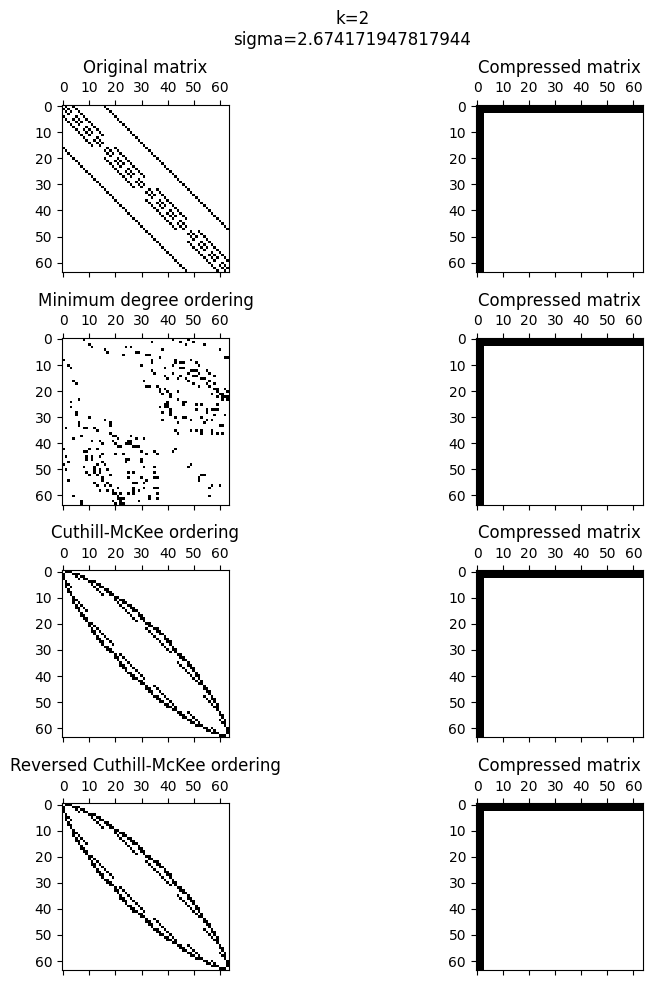

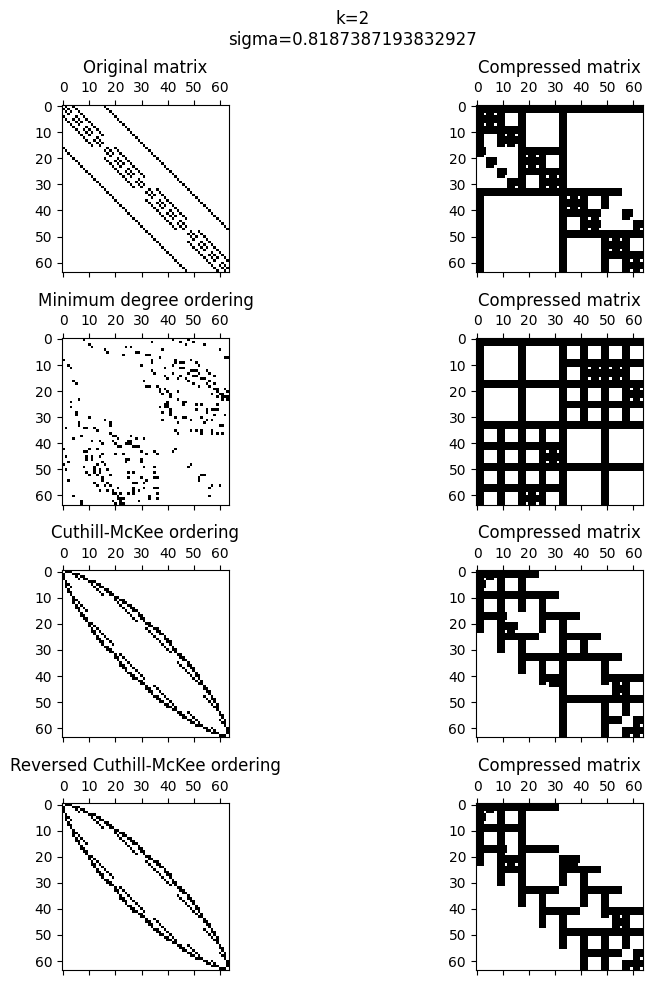

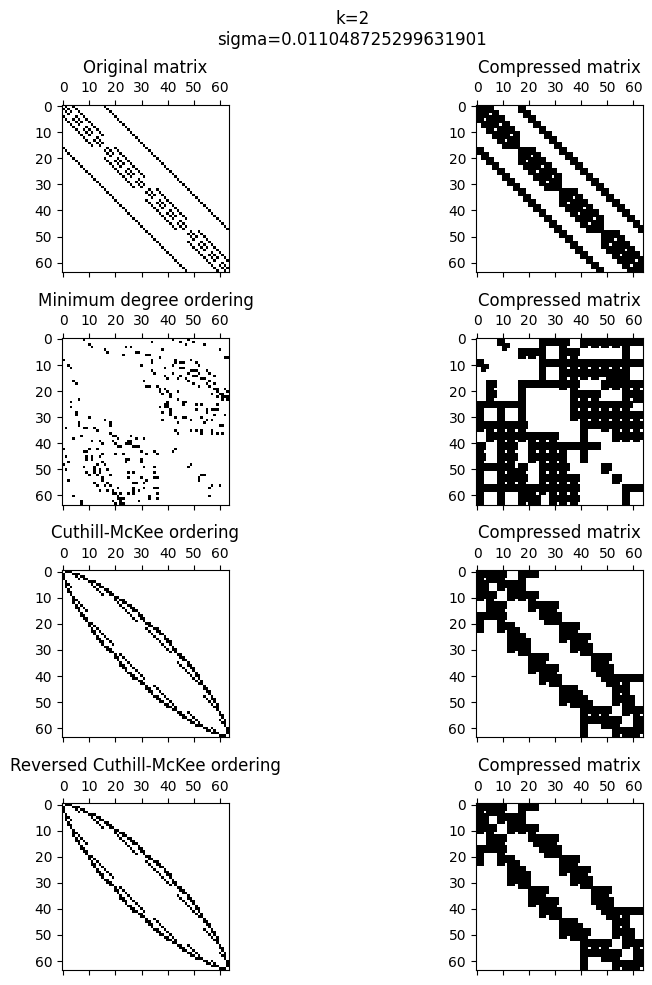

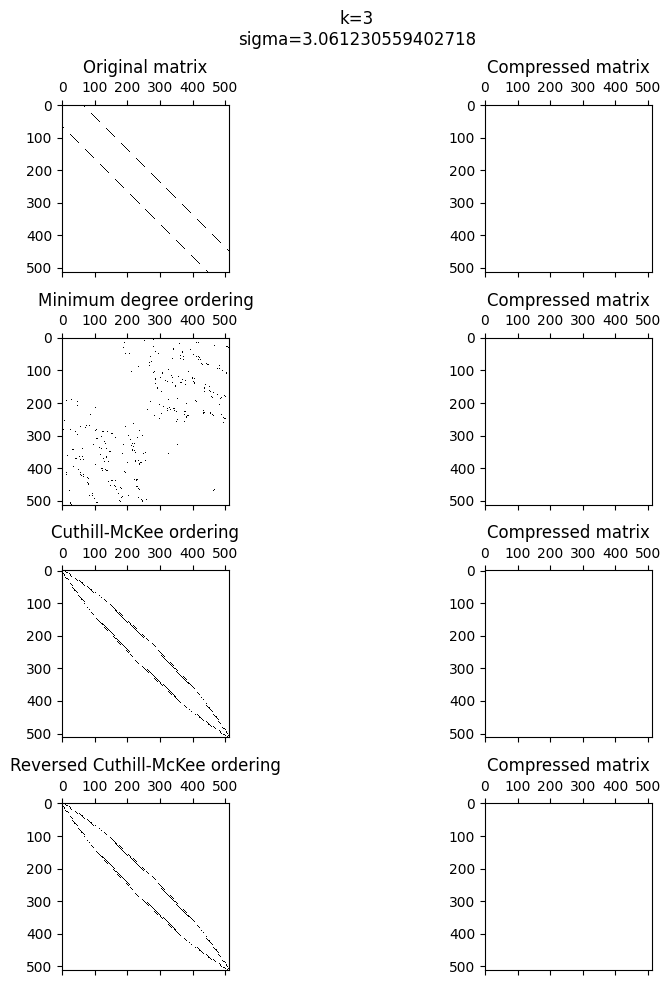

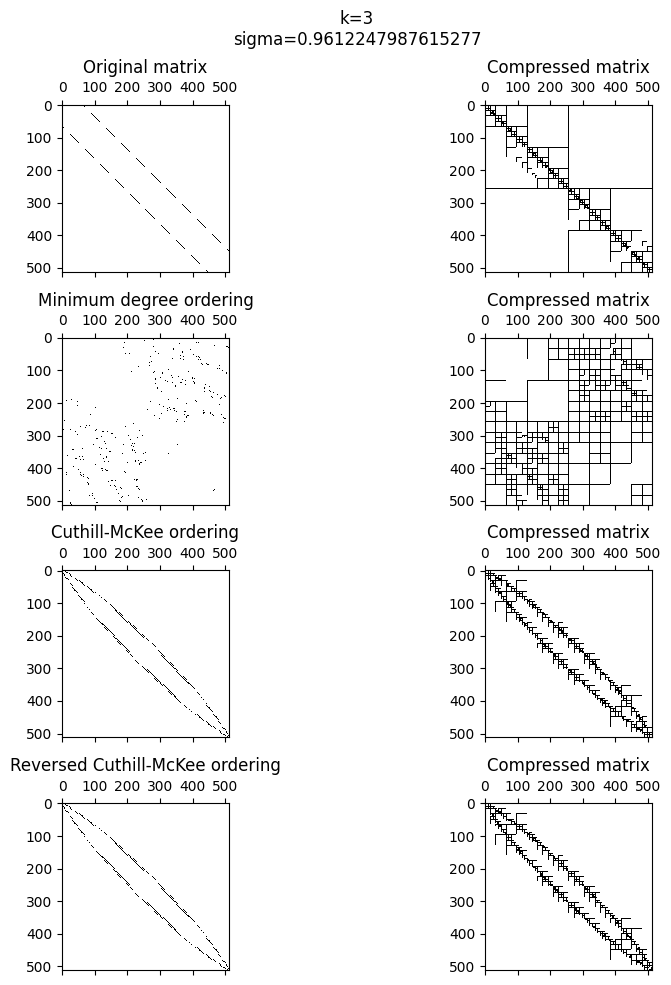

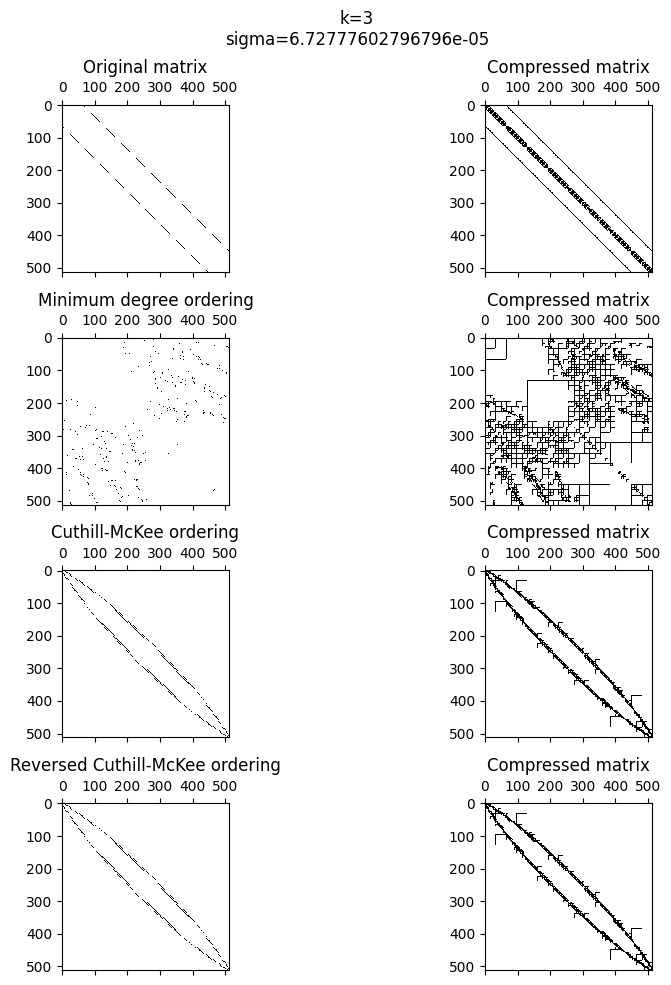

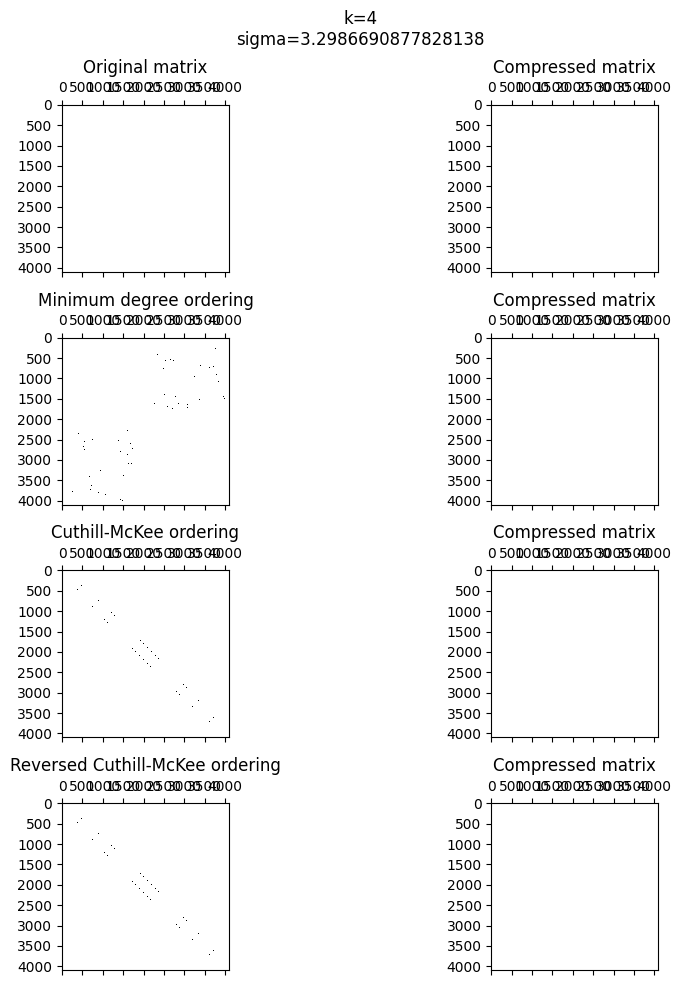

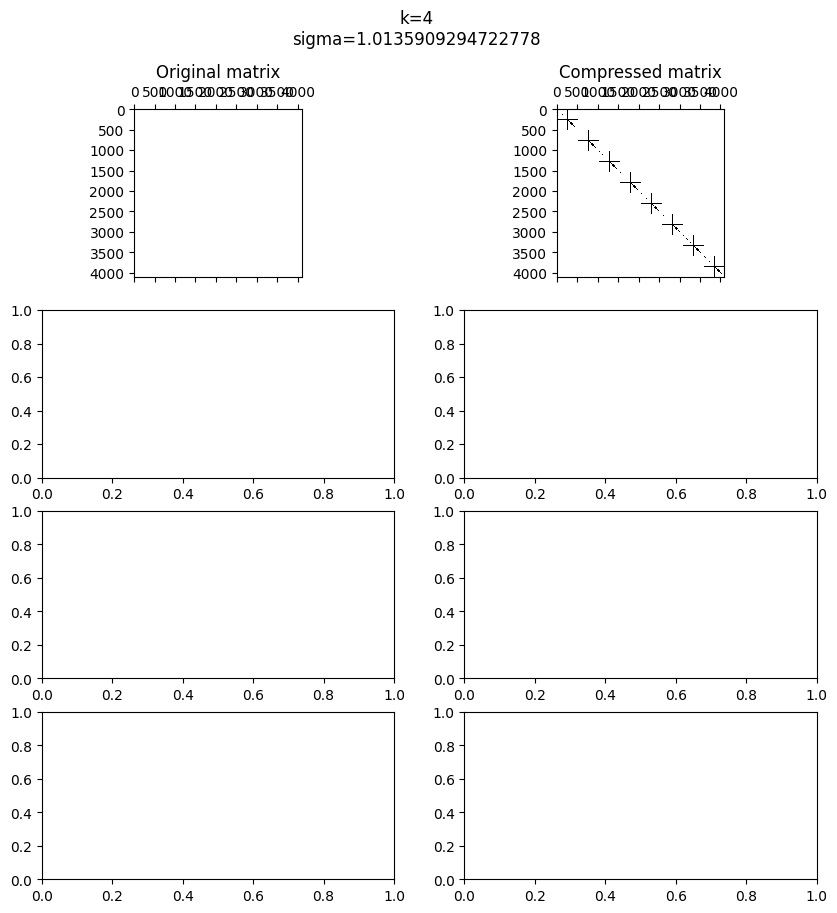

In [20]:
for k in (2, 3, 4):
    matrix = generate_3d_grid_matrix(k).toarray()
    _, S, _ = np.linalg.svd(matrix)
    for sigma in (S[0], S[len(S)//2], S[-1]):
        plot_test_results(matrix, sigma, f"k={k}\nsigma={sigma}")

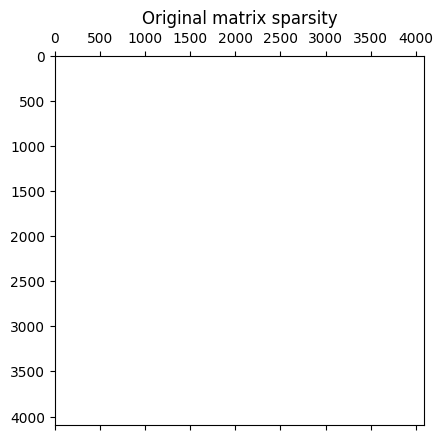

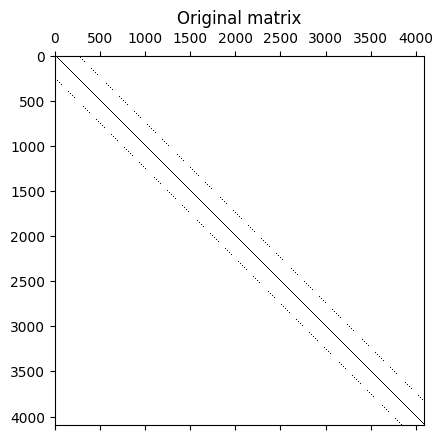

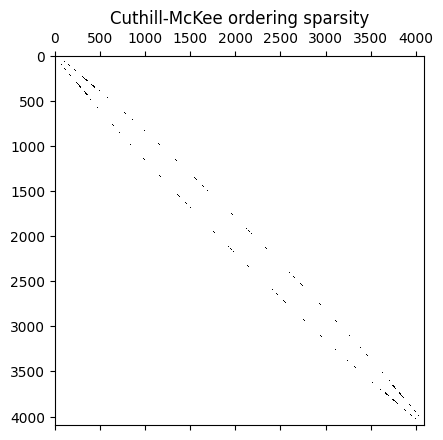

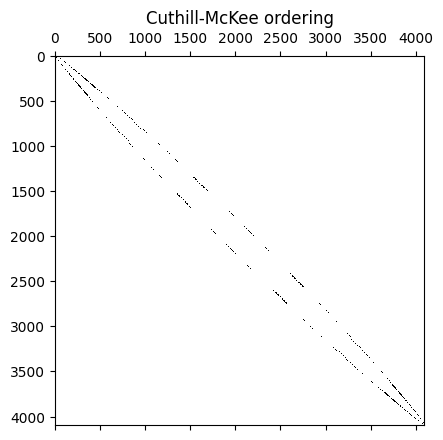

In [ ]:
matrix = generate_3d_grid_matrix(4).toarray()
root = create_tree(matrix, 3, 10**(-8))
plot_sparisity(matrix, "Original matrix sparsity")
plot_matrix(root, matrix, "Original matrix")

perm_matrix = permutate_matrix(matrix, cuthill_mckee_ordering(matrix))
root = create_tree(perm_matrix, 3, 10**(-8))
plot_sparisity(perm_matrix, "Cuthill-McKee ordering sparsity")
plot_matrix(root, perm_matrix, "Cuthill-McKee ordering")

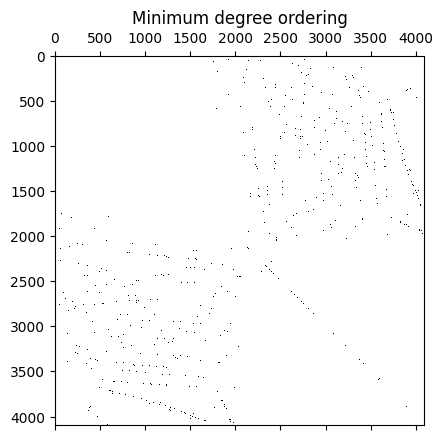

In [ ]:
perm_matrix = permutate_matrix(matrix, minimum_degree_ordering(matrix))
root = create_tree(perm_matrix, 3, 10**(-8))
# plot_sparisity(perm_matrix, "Minimum degree ordering sparsity")
plot_matrix(root, perm_matrix, "Minimum degree ordering")